In [48]:
import numpy as np
import pymc as pm
from pytensor import tensor as pt
from pytensor.gradient import verify_grad
import arviz as az
import matplotlib.pyplot as plt
import umbridge
from umbridge.pymc import UmbridgeOp

# Set up a pytensor op connecting to UM-Bridge model
op = UmbridgeOp("http://localhost:4242", "posterior2")

# Define input parameter
input_dim = 2

with pm.Model() as model:
    # UM-Bridge models with a single 1D output implementing a PDF
    # may be used as a PyMC density that in turn may be sampled
    posterior = pm.DensityDist('posterior',logp=op,shape=input_dim)

    prior_covariance = np.array([[1e-2, 0], [0, 1e-2]])
    prior_mean = np.array([3.6, 1.1])

    inferencedata = pm.sample(tune=100,step=pm.Metropolis(S=prior_covariance),draws=500,chains=1,cores=1,initvals=[{'posterior':prior_mean}])



Sequential sampling (1 chains in 1 job)
Metropolis: [posterior]


Output()

Sampling 1 chain for 100 tune and 500 draw iterations (100 + 500 draws total) took 48 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


array([<Axes: title={'center': 'posterior\n0'}>,
       <Axes: title={'center': 'posterior\n1'}>], dtype=object)

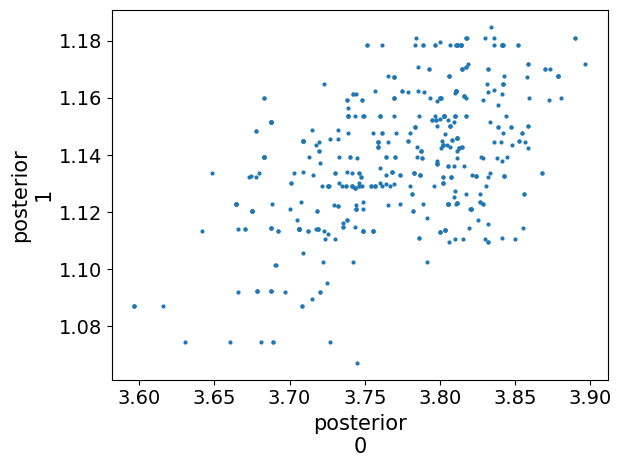

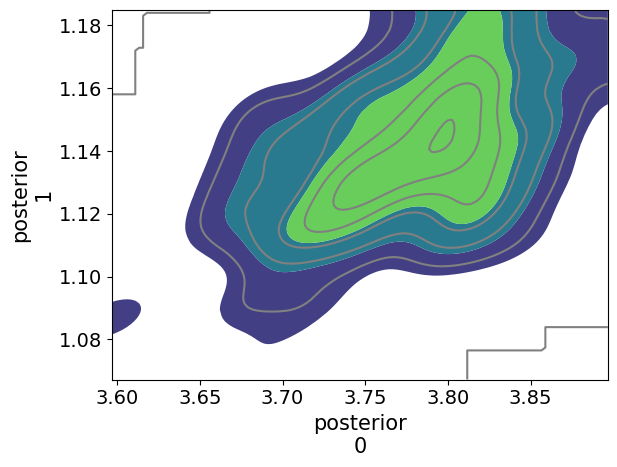

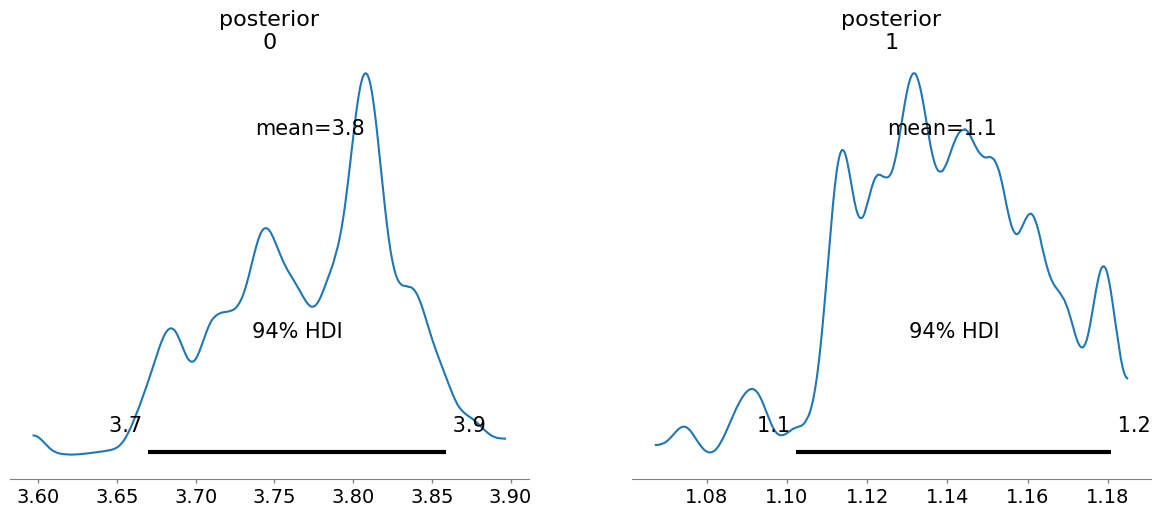

In [52]:
az.plot_pair(inferencedata);
az.plot_pair(inferencedata, kind='kde')
az.plot_posterior(inferencedata)

In [53]:
earth_radius = 6371 # km
earth_position = [0, 0] # km

moon_radius = 1737 # km
moon_position = [384400 * 0.1, 0] # km

observation_1e4 = [26196.977047775636, 7987.481087658843] # km
observation_2e4 = [47165.76552360456, 2789.596292820795] # km

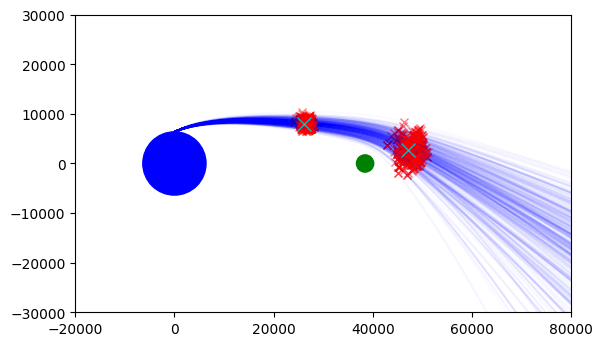

In [54]:

import matplotlib.pyplot as plt

model = umbridge.HTTPModel("http://localhost:4242", "forward")

plt.gca().set_aspect('equal', adjustable='box')
plt.gca().set_xlim([-2e4, 8e4])
plt.gca().set_ylim([-3e4, 3e4])

# plot earth
circ = plt.Circle((0, 0), earth_radius, color='b', fill=True)
plt.gcf().gca().add_artist(circ)

# plot moon
circ = plt.Circle((moon_position[0], moon_position[1]), moon_radius, color='g', fill=True)
plt.gcf().gca().add_artist(circ)

# plot posterior predictive trajectories
for sample in inferencedata.posterior.posterior.values[0]:
    out = model([sample.tolist()])

    plt.plot(out[0], out[1], 'b', alpha=0.02)
    if (out[4] != [0,0]):
        plt.plot(out[4][0], out[4][1], 'rx', alpha=0.5)
    if (out[5] != [0,0]):
        plt.plot(out[5][0], out[5][1], 'rx', alpha=0.5)

# plot observation
plt.plot(observation_1e4[0], observation_1e4[1], 'cx', markersize=10)
plt.plot(observation_2e4[0], observation_2e4[1], 'cx', markersize=10)

plt.show()